In [0]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.layers import GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
# Training parameters
batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 50
data_augmentation = True

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)
print("model_type: ",model_type)

model_type:  ResNet20v1


In [0]:
# Load the CIFAR10 data.
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 6s 0us/step


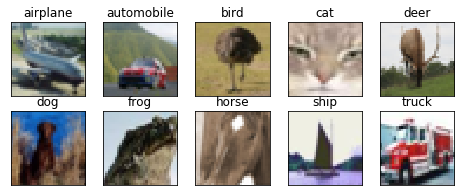

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

Text(0.5, 1.0, 'Class ID: 2')

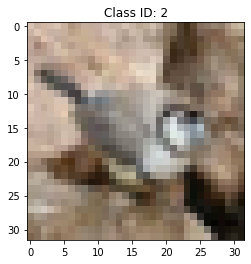

In [0]:
img_num = 90
plt.imshow(train_features[img_num])
plt.title("Class ID: {}".format(train_labels[img_num][0]))

In [0]:
# Input image dimensions.
input_shape = train_features.shape[1:]

# Normalize data.
x_train = train_features.astype('float32') / 255
x_test = test_features.astype('float32') / 255

y_train = train_labels
y_test = test_labels

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters = 2*num_filters

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [0]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.01),
              metrics=['accuracy'])

In [0]:
def lr_schedule_custom(epoch, lr):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after each epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = round(0.1 * 1/(1 + 0.1 * epoch), 10) # 0.01, 0.319
    return lr

def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 35:
        lr *= 0.5e-3
    elif epoch > 25:
        lr *= 1e-3
    elif epoch > 15:
        lr *= 1e-2
    elif epoch > 5:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [0]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models4')
#model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
model_name = 'cifar10_%s_model_best.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule_custom, verbose=1)
#lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=2, #patience=5
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer]

In [0]:
def cutout_custom(img):

    height = img.shape[0]
    width = img.shape[1]
    depth = img.shape[2]

    CUT_SIZE = height//2

    img_new = np.zeros((width+2*CUT_SIZE,height+2*CUT_SIZE, depth), np.float32)

    # normalize before adding the mask
    #mean = img.mean(keepdims=True)
    mean = np.mean(img, axis=(0, 1))
    img -= mean

    img_new[CUT_SIZE:width+CUT_SIZE,CUT_SIZE:height+CUT_SIZE,:] = img
    #print(mean)

    mask = np.ones((width+2*CUT_SIZE,height+2*CUT_SIZE,depth), np.float32)
 
    y1 = np.random.randint(height+CUT_SIZE)
    y2 = y1 + CUT_SIZE
    x1 = np.random.randint(width+CUT_SIZE)
    x2 = x1 + CUT_SIZE

    mask[y1: y2, x1: x2,:] = 0

    # apply mask
    img_new = img_new * mask

    # denormalize
    img_new += mean

    final_img = img_new[CUT_SIZE:width+CUT_SIZE,CUT_SIZE:height+CUT_SIZE,:]

    return final_img

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
print(model_type)
model.summary()

ResNet20v1
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
_________________________________________________________________________________

In [0]:
# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model_hist = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
              # set range for random shear
              #shear_range=0.1,
              # set range for random zoom
              #zoom_range=0.1,
              # randomly flip images
              horizontal_flip=True,
              # set function that will be applied on each input
              preprocessing_function=cutout_custom
        )

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model_hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)

Using real-time data augmentation.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
391/391 [==============================] - 23s 58ms/step - loss: 1.8077 - acc: 0.4066 - val_loss: 1.7941 - val_acc: 0.4156

Epoch 00001: val_acc improved from -inf to 0.41560, saving model to /content/saved_models4/cifar10_ResNet20v1_model_best.h5
Epoch 2/50
391/391 [==============================] - 16s 41ms/step - loss: 1.4021 - acc: 0.5700 - val_loss: 1.6726 - val_acc: 0.4956

Epoch 00002: val_acc improved from 0.41560 to 0.49560, saving model to /content/saved_models4/cifar10_ResNet20v1_model_best.h5
Epoch 3/50
391/391 [==============================] - 16s 42ms/step - loss: 1.2621 - acc: 0.6345 - val_loss: 1.3288 - val_acc: 0.6280

Epoch 00003: val_acc improved from 0.49560 to 0.62800, saving model to /content/saved_models4/cifar10_ResNet20v1_model_best.h5
Epoch 4/50
391/391 [==============================] - 16s 41ms/step - loss: 1.1813 - a

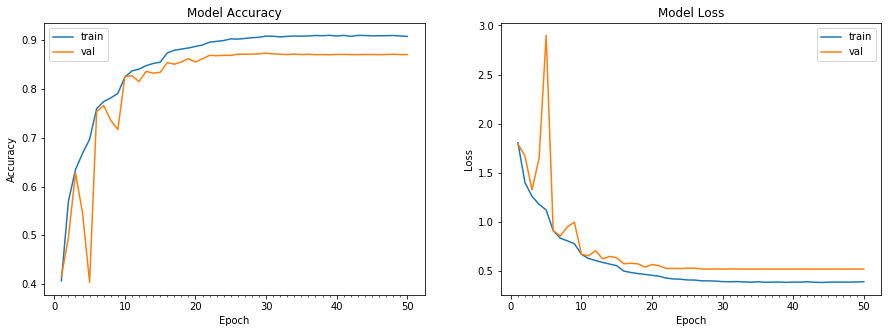

In [0]:
plot_model_history(model_hist)

In [0]:
from keras.models import load_model
best_model = load_model("/content/saved_models4/cifar10_ResNet20v1_model_best.h5")

In [0]:
# Score trained model.
scores = best_model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 2s 227us/step
Test loss: 0.5218558529853821
Test accuracy: 0.8737


# GRADCAM

In [0]:
from keras.preprocessing import image
import cv2
from skimage import io

def gradCAM(bmodel, lastLayerName, img_inp, plot_result=False):

  # 1. Use expand_dims to convert image to a batch of size 1
  # 2. Preprocesing normalizes our input image by subtracting mean RGB values

  x = image.img_to_array(img_inp)
  x = np.expand_dims(img_inp, axis=0)
  #print("Image Size: ", test_inp.shape)
  #print("Expand Image Size: ", x.shape)

  # normalize
  x = x.astype('float32') / 255

  # If subtract pixel mean is enabled
  if subtract_pixel_mean:
    x -= x_train_mean

  # 1. We get the predictions for the image
  # 2. We take the topmost class index
  # 3. Take output from the final convolutional layer
  preds = bmodel.predict(x)
  class_idx = np.argmax(preds[0])
  #print(class_idx)
  class_output = bmodel.output[:, class_idx]
  last_conv_layer = bmodel.get_layer(lastLayerName)


  # 1. Compute the gradient of the class output value with respect to the feature map
  # 2. Pool the gradients over all the axies leaving out the channel dimension
  # 3. Weigh the output feature map with the computed gradient values
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  #print("grads shape: ", grads.shape)
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  #print("pooled_grads shape: ", pooled_grads.shape)
  iterate = K.function([best_model.input], [pooled_grads, last_conv_layer.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(64):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  # 1. Average the weighted feature map along the channel dimension resulting in a heat map of size 8x8
  # 2. Normalize the heat map to make the values between 0 and 1
  heatmap = np.mean(conv_layer_output_value, axis = -1)
  #print("conv_layer_output_value shape: ", conv_layer_output_value.shape)
  #print("heatmap shape: ", heatmap.shape)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  # Show the results
  heatmap = cv2.resize(heatmap, (img_inp.shape[1], img_inp.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img_inp, 0.5, heatmap, 0.5, 0)

  if plot_result:
    #from google.colab.patches import cv2_imshow
    #cv2_imshow( test_inp)
    #cv2_imshow(superimposed_img)

    fig, axs = plt.subplots(1,2,figsize=(8,5))
    axs[0].imshow(img_inp)
    axs[0].set_title('Pred: {}'.format(class_names[class_idx]))

    axs[1].imshow(superimposed_img)
    axs[1].set_title('With Heatmap')
  
  return superimposed_img, class_idx



Random Test Images:  [559 257 606 469 574 987 677 730 448 390]


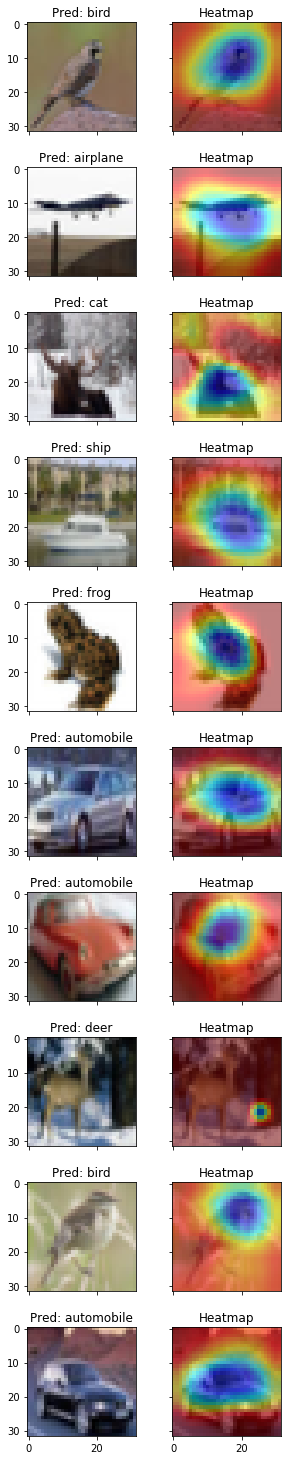

In [0]:
from mpl_toolkits.axes_grid1 import ImageGrid

num_row, num_col = 10, 2
fig = plt.figure(1, figsize=(15, 26))
grid = ImageGrid(fig, 111, nrows_ncols=(num_row, num_col), axes_pad=0.5)
i = 0

randnums= np.random.randint(0,1000,10) # 10 random test images
print("Random Test Images: ", randnums)

for img_num in randnums:    

    inp_image = test_features[img_num]

    superimposeImg, classid = gradCAM(best_model, "conv2d_21", inp_image)
    
    ax = grid[i] 
    ax.set_title('Pred: {}'.format(class_names[classid]))
    ax.imshow(inp_image)
    i += 1
    
    ax = grid[i]
    ax.set_title("Heatmap")
    ax.imshow(superimposeImg)
    i += 1
    
#fig.savefig('cifar10_gradCAM.png', dpi=300)
plt.show();